# More on Model Development
------------
Herewith this notebook I will investigate a few other ideas for improving model performance on the `class-1` known as `disengaged`.

1. Firstly, I will try another algorithm
2. Secondly, I will train and test a model just for engineered features and not including word vectors.
3. Thirdly, I will clean the text feature  to see if the model can pick up some other effective features.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')


from pathlib import Path
import sys
sys.path.append("..")

from rustoked.data_processing import(
    clean_raw_dataframe,
    get_labels,
    get_normalized_series,
    get_features,
    get_punct_removed
)

from rustoked.model_development import(
    get_vectorizer,
    get_vectors_list,
    get_features_and_labels,
    get_metrics,
    get_cm_plot,
    get_feature_importance
)

import warnings
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to /home/sakima/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sakima/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load the data and get dataframe ready for further processes.

In [2]:
df = pd.read_csv(Path("../data/raw_data.csv"))
df = clean_raw_dataframe(df.copy())
df = get_features(df.copy())

### 1. Naive Bayes Model

As suggested by [scikit-learn guide](https://docs.google.com/document/d/1u-sHT0PU7114OV4cBuJ6AkFpHDYShLWjtN2Pt0yn08s/edit) to estimators I use a `Naive Bayes` model here. As Results show, no significant changes in outcomes.

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=69)

vectorizer = get_vectorizer(train_df)

train_df["vectors"] = get_vectors_list(train_df["reviews"], vectorizer)
test_df["vectors"] = get_vectors_list(test_df["reviews"], vectorizer)

In [4]:
clf = MultinomialNB()

X_train, y_train = get_features_and_labels(train_df)
X_test, y_test = get_features_and_labels(test_df)

clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

In [5]:
get_metrics(y_test, y_predicted)

              precision    recall  f1-score   support

           0       0.73      0.68      0.70       736
           1       0.35      0.02      0.03       489
           2       0.67      0.96      0.79      1196

    accuracy                           0.68      2421
   macro avg       0.58      0.55      0.51      2421
weighted avg       0.62      0.68      0.61      2421



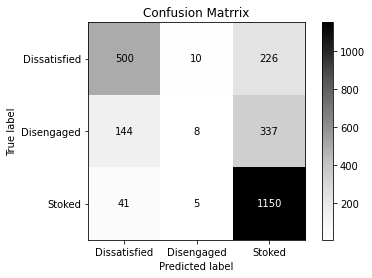

In [6]:
get_cm_plot(clf, X_test, y_test)

### 2. Engineered Features without Word-Vectors

By this model, I just use generated features from text and not the text vectors themselves. **_Interestingly_**, at the cost of lower performance on labels `“Dissatisfied”` and `“Stoked”`, it shows some improvement on detecting the `“Disengaged”` class.

I suppose working more on investigating the text data and extracting more predictive features should result in better performance not only on the `class-1` but also the two other classes.

In [7]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True, n_jobs=2)

features_name = ["review_len", 
                 "has_positive", 
                 "has_but", 
                 "has_negative", 
                 "great_count", 
                 "good_count", 
                 "bad_count", 
                 "poor_count", 
                 "not_count", 
                 "no_count", 
                 "n't_count", 
                 "pos_neg_factor"]

X_train = train_df[features_name].astype(float)
y_train = train_df["labels"]

X_test = test_df[features_name].astype(float)
y_test = test_df["labels"]

clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

In [8]:
get_metrics(y_test, y_predicted)

              precision    recall  f1-score   support

           0       0.48      0.49      0.48       736
           1       0.25      0.25      0.25       489
           2       0.63      0.63      0.63      1196

    accuracy                           0.51      2421
   macro avg       0.45      0.45      0.45      2421
weighted avg       0.51      0.51      0.51      2421



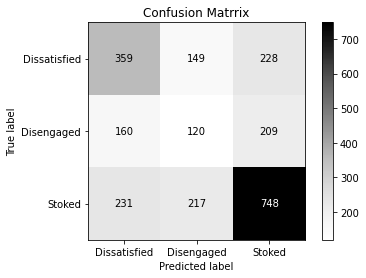

In [9]:
get_cm_plot(clf, X_test, y_test)

### 3. Super Cleaned Text

In this scenario, I cleaned the text deeper using `NLTK` to remove stop words and lemmatize text to see if the model can pick up more meaningful relationships between words and improve the performance. As expected (recommended not to heavily clean the text by **Tomas Mikolov**, see [here](https://groups.google.com/forum/#!msg/word2vec-toolkit/jPfyP6FoB94/tGzZxScO0GsJ) thanks to [**Jason Brownlee**](https://machinelearningmastery.com/clean-text-machine-learning-python/)), there was not much change comparing to the other models performing on full text.

In [10]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
sk_vectorizer = TfidfVectorizer(strip_accents='ascii', max_df=0.5, min_df=5, max_features=5000)

In [11]:
df_cleaned = df[["reviews", "labels"]]
df_cleaned["cleantxt"] = df_cleaned["reviews"].str.lower()
df_cleaned["cleantxt"] = df_cleaned["cleantxt"].apply(lambda x: get_punct_removed(x))
df_cleaned["cleantxt"] = df_cleaned["cleantxt"].apply(lambda x: tokenizer.tokenize(x))
df_cleaned["cleantxt"] = df_cleaned["cleantxt"].apply(
    lambda x: [word for word in x if word not in stopwords.words('english')])
df_cleaned["cleantxt"] = df_cleaned["cleantxt"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x]))

In [12]:
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=69)

sk_vectorizer.fit(train_df["cleantxt"])

train_df["vectors"] = get_vectors_list(train_df["cleantxt"], sk_vectorizer)
test_df["vectors"] = get_vectors_list(test_df["cleantxt"], sk_vectorizer)

In [13]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True, n_jobs=2)

X_train, y_train = get_features_and_labels(train_df)
X_test, y_test = get_features_and_labels(test_df)

clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

In [14]:
get_metrics(y_test, y_predicted)

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       736
           1       0.41      0.03      0.06       489
           2       0.69      0.92      0.79      1196

    accuracy                           0.68      2421
   macro avg       0.59      0.56      0.51      2421
weighted avg       0.63      0.68      0.61      2421



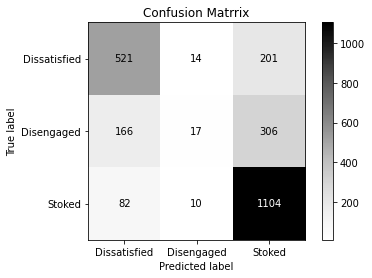

In [15]:
get_cm_plot(clf, X_test, y_test)